# Bayesian Mixture of Gaussians in edward2

A similar tutorial is written with tfp:
https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/Bayesian_Gaussian_Mixture_Model.ipynb

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="7"

In [2]:
from functools import partial
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
Variable = tf.Variable
import tensorflow_probability as tfp
tfd = tfp.distributions
ed = tfp.edward2

print('TensorFlow version {}, TF Probability version {}.'.format(tf.__version__, tfp.__version__))

TensorFlow version 1.10.0, TF Probability version 0.4.0.


In [3]:
def mog_model(d, k, n):
    pi = ed.Dirichlet(concentration=tf.ones(k)*.1, name='pi')
    mu = ed.MultivariateNormalDiag(loc=tf.zeros([k, d]), scale_identity_multiplier=tf.ones([k]), name='mu')
    sigmasq = ed.InverseGamma(concentration=tf.ones([k]), rate=tf.ones([k]), name='sigmasq')
    
    mixture = tfd.Categorical(probs=pi,name='mixture')
    mixture_components = tfd.MultivariateNormalDiag(
        loc=mu, scale_identity_multiplier=sigmasq, name='mixture_components')
    
    x = ed.MixtureSameFamily(
        mixture_distribution=mixture, components_distribution=mixture_components, sample_shape=n, name='x')
    return x, (pi, mu, sigmasq)

def variational_model(d, k):
    qpi = tf.nn.softmax(tf.ones([k]))
    qmu = tf.random_normal([k, d])
    qsigmasq = tf.nn.softplus(tf.ones([k]))
    return qpi, qmu, qsigmasq

def replace_latents(qpi, qmu, qsigmasq):
    def interceptor(rv_constructor, *rv_args, **rv_kwargs):
        name = rv_kwargs.pop('name')
        if name == 'pi':
            rv_kwargs['value'] = qpi
        elif name == 'mu':
            rv_kwargs['value'] = qmu
        elif name == 'sigmasq':
            rv_kwargs['value'] = qsigmasq
        return rv_constructor(*rv_args, **rv_kwargs)
    return interceptor

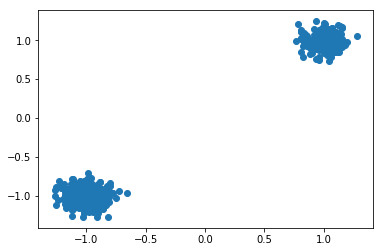

In [4]:
# Generate data by setting ("intercepting") latent variables.
d, k, n = 2, 2, 500
pi = np.array([.4, .6])
mus = [[1, 1], [-1, -1]]
stds = [0.1, 0.1]

with ed.interception(replace_latents(qpi=pi, qmu=mus, qsigmasq=stds)):
    generate = mog_model(d=d, k=k, n=n)
with tf.Session() as sess:
    data, _ = sess.run(generate)
plt.scatter(data[:, 0], data[:, 1])

In [5]:
log_joint = ed.make_log_joint_fn(mog_model)
qpi, qmu, qsigmasq = variational_model(d=d, k=k)
def target(qpi, qmu, qsigmasq):
    return log_joint(d=d, k=k, n=n, pi=qpi, sigmasq=qsigmasq, mu=qmu, x=data)

hmc_kernel = tfp.mcmc.HamiltonianMonteCarlo(
    target_log_prob_fn=target, step_size=1e-3, num_leapfrog_steps=5)
states, kernels_results = tfp.mcmc.sample_chain(
    num_results=2000, current_state=[qpi, qmu, qsigmasq], kernel=hmc_kernel, num_burnin_steps=1000)

with tf.Session() as sess:
    (mcmc_pi, mcmc_mu, mcmc_sigmasq) ,_results = sess.run([states, kernels_results])

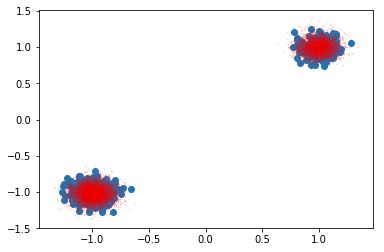

In [6]:
_pi, _mu, _sigmasq = mcmc_pi[-1], mcmc_mu[-1], mcmc_sigmasq[-1]
with ed.interception(replace_latents(qpi=_pi, qmu=_mu, qsigmasq=_sigmasq)):
    generate = mog_model(d=d, k=k, n=1e4)
    
with tf.Session() as sess:
    generated, _ = sess.run(generate)
plt.scatter(data[:, 0], data[:, 1])
plt.scatter(generated[:, 0], generated[:, 1], c='r', s=.1, alpha=.3)